In [50]:
import pybamm 
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgest
pybamm.set_logging_level(50)


In [51]:
factor = 5.0
capacities = []
specific_capacities = []
solution = []
l_p = 1e-4
thicknesses = np.linspace(1.0, 2.5, 11) * l_p

In [53]:
thicknesses

array([0.0001  , 0.000115, 0.00013 , 0.000145, 0.00016 , 0.000175,
       0.00019 , 0.000205, 0.00022 , 0.000235, 0.00025 ])

In [67]:
import time as ticker_time
st = ticker_time.time()
for l_n in thicknesses:
    solution.append([])
    e_ratio = np.around(l_n / l_p,3)
    h = 0.137
    w = 0.207 / factor
    A = h * w
    l_s = 2.5e-5
    lid = l_n + l_p + l_s
    vol = h*w*lid
    vol_cm3 = vol * 1e6
    tot_cap = 0.0
    tot_time = 0.0

    I_mag = 1.00 / factor

    print("*" * 60)
    print("Anode Thickness" + str(np.around(l_n*1e6,3))+ 'um')
    for enum, I_app in enumerate([-1.0,1.0]):
        I_app *= I_mag
        model = pybamm.lithium_ion.SPMe()
        geometry = model.default_geometry
        param = model.default_parameter_values
        param.update(
            {
                "Electrode height [m]":h,
                "Electrode width [m]":w,
                "Negative electrode thickness [m]":l_n,
                "Positive electrode thickness [m]":l_p,
                "Separator thickness [m]":l_s,
                # "Lower voltage cut-off [V]":2.8,
                # "Upper voltage cut-off [V]":4.7,
                
                # "Maximum concentration in negative electrode [mol.m-3]":25000,
                # "Maximum concentration in positive electrode [mol.m-3]":50000,
                # "Initial concentration in negative electrode [mol.m-3]":12500,
                # "Initial concentration in positive electrode [mol.m-3]":25000,
                # "Negative electrode active material volume fraction":180000.0,

                # "Positive electrode active material volume fraction'":180000.0,
                "Current function [A]":I_app,
            }
        )
        param.process_model(model)
        param.process_geometry(geometry)
        s_var = pybamm.standard_spatial_vars
        var_pts = {
            s_var.x_n : 5,
            s_var.x_s : 5,
            s_var.x_p : 5,
            s_var.r_n : 5,
            s_var.r_p : 10,
        }
        mesh = pybamm.Mesh(geometry, model.default_spatial_methods,var_pts)
        disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
        disc.process_model(model)

        t_eval = np.linspace(0,3600,100)
        sol = pybamm.CasadiSolver(mode = 'fast').solve(model, t_eval)
        time = sol["Time [h]"]
        time_secs = sol["Time [s]"].entries
        time_hours = time(time_secs)
        dc_time = np.around(time_hours[-1],3)

        cap = np.absolute(I_app * 1000 * dc_time)
        cap_time = np.absolute(I_app * 1000 * time_hours)
        print(
            "Applied Current",
            np.around(I_app, 3),
            "A",
            "Time",
            np.arround(dc_time, 3),
            "hrs",
            "Capacity",
            np.around(cap,3),
            "mAh"
        )
    print("Termination events:" + sol.termination)
    specitiv_cap = np.around(tot_cap,3)
    capacities.append(tot_cap)
    specific_capacities.append(specitiv_cap)
et = ticker_time.time()

************************************************************
Anode Thickness100.0um


KeyError: 'negative electrode'

In [43]:

# Define the PyBaMM model
model = pybamm.lithium_ion.SPM()

# Load parameter values
param = pybamm.ParameterValues("Chen2020")

# Define the solver
fast_solver = pybamm.CasadiSolver(atol=1e-3, rtol=1e-3, mode="fast")    

In [44]:
def mycurrnet(t):
    return pybamm.sin(t)

In [45]:
param['Current function [A]'] = mycurrnet
sim = pybamm.Simulation(model, parameter_values=param)
sim.solve(["Current [A]"])
t_eval = [0,100]
sim.solve(t_eval)

In [40]:
sim.plot()

<bound method Simulation.plot of <pybamm.simulation.Simulation object at 0x000001704BE05480>>

In [ ]:
import pandas as pd
# Import drive cycle from file
drive_cycle = pd.read_csv("/home/ubuntu/US06_3.csv", comment="#", header=None).to_numpy()

# Create interpolant
timescale = param.evaluate(model.timescale)
current_interpolant = pb.Interpolant(drive_cycle, timescale * pb.t)

# Set drive cycle
param["Current function [A]"] = current_interpolant

In [31]:
import pybamm
import numpy as np

# Define the PyBaMM model
model = pybamm.lithium_ion.SPM()

# Load parameter values
param = pybamm.ParameterValues("Chen2020")

# Define the solver
fast_solver = pybamm.CasadiSolver(atol=1e-3, rtol=1e-3, mode="fast")    

# Example current profile
current_profile = np.array([0.5] * 100)

time = 0
action = 0  # Example action (can be dynamic based on your RL algorithm)
while time < len(current_profile):
    
    
    # Take an action and return the next state
    if action == 0:
        current = 1.0  # Charging
        action = 1
        experiment = pybamm.Experiment(
            [
                "Discharge at 1C for 1min"
            ],
)
    else:
        current = -1.0  # Discharging
        action = 0 
        experiment = pybamm.Experiment(
            [
                "Charge at 1C for 1min"
            ],
)
    
    t_eval = [time, time + 1]  # Time interval for simulation step
    
    # Set the current profile as an external variable
    model.external_variables = {"Current function [A]": current_profile[time]}

    # Create a simulation object
    fast_sim = pybamm.Simulation(model, parameter_values=param, solver=fast_solver, experiment=experiment)
    
    # Solve the model
    solution = fast_sim.solve()
    
    # Extract the state at the end of the interval
    next_state = solution.y[:, -1]

    # Example reward function (could be based on battery performance, efficiency, etc.)
    # Reward calculation here

    # Update environment time
    time += 1

    # Check if episode is done (example: time limit reached)
    done = time >= len(current_profile)

    print(next_state)


[0.900528, 0.900487, 0.900402, 0.900267, 0.900075, 0.899813, 0.899467, 0.899017, 0.898441, 0.897711, 0.896798, 0.895667, 0.894282, 0.892605, 0.890603, 0.888244, 0.885508, 0.88239, 0.878904, 0.87508, 0.269999, 0.269999, 0.269999, 0.269999, 0.269999, 0.269999, 0.27, 0.270001, 0.270005, 0.270015, 0.270038, 0.270096, 0.270232, 0.270545, 0.271238, 0.272695, 0.275581, 0.280897, 0.289868, 0.303453]
[0.902267, 0.902308, 0.902393, 0.902528, 0.90272, 0.902982, 0.903328, 0.903778, 0.904354, 0.905084, 0.905997, 0.907128, 0.908513, 0.910189, 0.912191, 0.91455, 0.917286, 0.920405, 0.923891, 0.927716, 0.269999, 0.269999, 0.269999, 0.269999, 0.269999, 0.269998, 0.269998, 0.269996, 0.269992, 0.269983, 0.269959, 0.269902, 0.269766, 0.269452, 0.268759, 0.267302, 0.264416, 0.259101, 0.25013, 0.236544]
[0.900528, 0.900487, 0.900402, 0.900267, 0.900075, 0.899813, 0.899467, 0.899017, 0.898441, 0.897711, 0.896798, 0.895667, 0.894282, 0.892605, 0.890603, 0.888244, 0.885508, 0.88239, 0.878904, 0.87508, 0.269999

In [9]:
for i in range(3600):
    step(0)

NameError: name 'self' is not defined

In [ ]:
import gym
import numpy as np
import pybamm

class BatteryEnv(gym.Env):
    def __init__(self):
        super(BatteryEnv, self).__init__()
        # Define your PyBaMM battery model here
        self.model = pybamm.lithium_ion.DFN()
        self.current_profile = np.array([0.5]*100)  # Example current profile

        # Define action space (example: charge, discharge)
        self.action_space = gym.spaces.Discrete(2)  

        # Define observation space (example: voltage, current, state of charge)
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self):
        # Reset the environment
        self.time = 0
        self.state = self.model.y0  # Initial state
        self.model.time_update(0)
        return self.state

    def step(self, action):
        # Take an action and return the next state, reward, and done flag
        if action == 0:
            self.current = 1.0  # Charging
        else:
            self.current = -1.0  # Discharging
        
        t_eval = [self.time, self.time + 1]  # Time interval for simulation step
        self.model.input['Current function [A]'] = self.current_profile[self.time]
        solution = self.model.solve(t_eval)
        next_state = solution.y[:, -1]  # Extract the state at the end of the interval

        # Example reward function (could be based on battery performance, efficiency, etc.)
        reward = self.calculate_reward()

        # Update environment time
        self.time += 1

        # Check if episode is done (example: time limit reached)
        done = self.time >= len(self.current_profile)

        return next_state, reward, done, {}

    def calculate_reward(self):
        # Example reward calculation (could be based on battery performance metrics)
        return np.random.normal(0, 1)  # Placeholder for demonstration

    def render(self, mode='human'):
        pass

    def close(self):
        pass

# Example usage
env = BatteryEnv()
observation = env.reset()
for _ in range(100):
    action = env.action_space.sample()  # Random action selection
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()


In [5]:
model = pybamm.lithium_ion.SPM()
param= pybamm.ParameterValues("Chen2020")
fast_solver = pybamm.CasadiSolver(atol=1e-3, rtol=1e-3, mode="fast")    
I_mean = 3
experiment = pybamm.Experiment(
    [
        "Discharge at 1C until 2.3V",
        "Rest for 3 hours"
    ],
)

fast_sim = pybamm.Simulation(model,parameter_values=param, experiment=experiment,solver=fast_solver)
#param.update({"Current function [A]":cu})
solution = fast_sim.solve(save_at_cycles=[1])






In [2]:
import random
#from utils.desired_decimal_point_generator import desired_decimal_point_generator
import logging


def experiment_generator(testing={"rest1": False, "rest2": False}):
    """
    This function generates a random experiment with the template
    ["Discharge", "Rest?", "Charge", "Hold", "Rest?"].

    Parameters
    ----------

        testing : dict
            default : {"rest1": False, "rest2": False}
            This should only be used while testing, to generate some
            not so random experiments.

    Returns
    -------
        cycle : list
    """
    charge = []
    discharge = []
    rest = []
    hold = []

    vmin = random.randint(3, 4)
    vmax = random.randint(3, 4)
    ccharge = random.randint(1, 3)
    cdischarge = random.randint(1, 3)
    ccutoff = random.randint(1, 100)

    discharge.append(
        "Discharge at " + str(cdischarge) + " C until " + str(vmin) + " V",
    )

    charge.append(
        "Charge at " + str(ccharge) + " C until " + str(vmax) + " V",
    )

    rest.append(
        [
            "Rest for " + str(random.randint(1, 10)) + " minutes",
            "Rest for " + str(random.randint(1, 10)) + " minutes",
        ]
    )

    hold.append(
        "Hold at " + str(vmax) + " V until " + str(ccutoff) + " mA",
    )

    random.shuffle(rest)

    cycle = []

    cycle.append(discharge[0])
    if random.randint(0, 1) == 1 or testing["rest1"]:
        cycle.append(rest[0][0])
    cycle.append(charge[0])
    cycle.append(hold[0])
    if random.randint(0, 1) == 1 or testing["rest2"]:
        cycle.append(rest[0][1])

    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logger.info(str([tuple(cycle)]))

    return [tuple(cycle)]

In [10]:
# experiment = experiment
# battery_info = {
#     "Voltage": solution["Terminal voltage [V]"].entries[-1],
#     "Temperature": solution["X-averaged cell temperature [K]"].entries[-1],
#     # Add more battery information as needed
# }
# solution.plot()

{'Terminal voltage [V]': array([4.06340139, 3.9913449 , 3.98517081, 3.97897896, 3.96706016,
        3.95099024, 3.93325359, 3.91550438, 3.898516  , 3.88270539,
        3.86810073, 3.85458926, 3.84197582, 3.82996079, 3.81821828,
        3.80626766, 3.7934146 , 3.77864321, 3.76070092, 3.73927869,
        3.7163978 , 3.69481707, 3.67550143, 3.65806146, 3.64200647,
        3.62715594, 3.61349088, 3.60093381, 3.5893587 , 3.5785934 ,
        3.56844701, 3.55875003, 3.54931149, 3.53995944, 3.53051866,
        3.52079699, 3.51058349, 3.4996039 , 3.48755749, 3.47414857,
        3.45917477, 3.44265561, 3.42494166, 3.40670244, 3.38874508,
        3.37171826, 3.35589478, 3.34110755, 3.32672174, 3.31148857,
        3.29312573, 3.2677462 , 3.23035931, 3.17905483, 3.12007968,
        3.06149722, 3.00096913, 2.92490386, 2.81118853, 2.62546733,
        2.31020444, 2.30001288, 2.45657743, 2.76974051, 2.81315799,
        2.82659134, 2.8323068 , 2.83564548, 2.83792086, 2.8397696 ,
        2.84119089, 2.84

In [39]:
t_eval_1 = [60,120]
initial_solution = fast_sim.solve(t_eval_1)
initial_solution.plot()

2024-04-03 14:36:42.568 - [WARNING] simulation.solve(590): Ignoring t_eval as solution times are specified by the experiment


interactive(children=(FloatSlider(value=0.0, description='t', max=4.000412843712917, step=0.04000412843712917)…

AttributeError: 'str' object has no attribute 'type'

In [28]:
pybamm.Simulation(model)

In [17]:
fast_sim.solution.cycles[0].plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0004128437129174, step=0.01000412843712917…

In [24]:
exp = pybamm.step._Step(typ = 'c_rate',value = 2,duration = '1min' )

sim = pybamm.Simulation(model, experiment=experiment,)
sim.solve()
sim.plot()

Elapsed time (no Dask) = 4.70 s


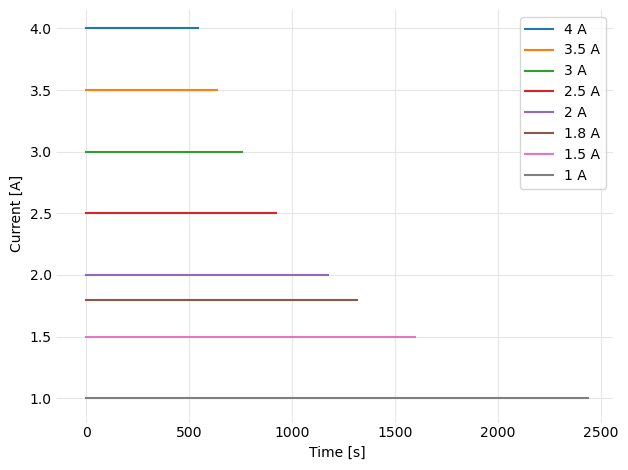

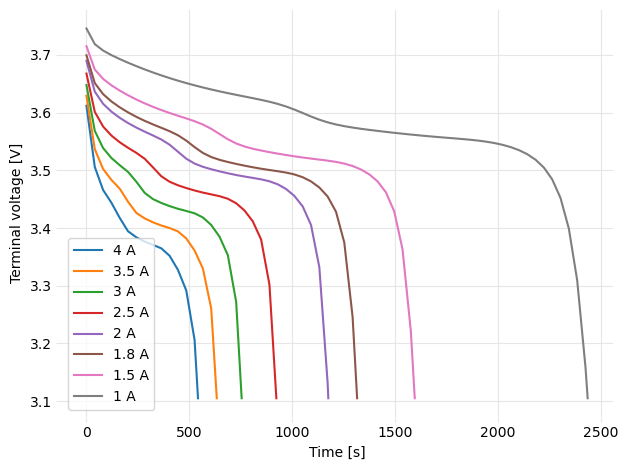

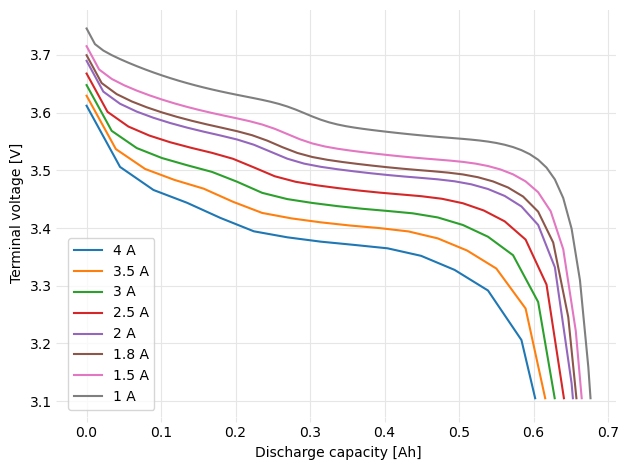

In [3]:
import matplotlib.pyplot as plt
import pybamm
import time
#from dask.distributed import Client


def create_plots(discharge, t, capacity, current, voltage):

    def styleplot(ax, xlabel, ylabel):
        ax.legend(loc='best')
        ax.grid(color='0.9')
        ax.set_frame_on(False)
        ax.tick_params(color='0.9')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    _, ax = plt.subplots(tight_layout=True)
    for i in range(len(discharge)):
        ax.plot(t[i], current[i], label=f'{discharge[i]} A')
    styleplot(ax, xlabel='Time [s]', ylabel='Current [A]')

    _, ax = plt.subplots(tight_layout=True)
    for i in range(len(discharge)):
        ax.plot(t[i], voltage[i], label=f'{discharge[i]} A')
    styleplot(ax, xlabel='Time [s]', ylabel='Terminal voltage [V]')

    _, ax = plt.subplots(tight_layout=True)
    for i in range(len(discharge)):
        ax.plot(capacity[i], voltage[i], label=f'{discharge[i]} A')
    styleplot(ax, xlabel='Discharge capacity [Ah]', ylabel='Terminal voltage [V]')

    plt.show()

def run_simulation(dis, t_eval):

    model = pybamm.lithium_ion.SPMe()

    param = model.default_parameter_values
    param['Current function [A]'] = '[input]'

    sim = pybamm.Simulation(model, parameter_values=param)
    sim.solve(t_eval, inputs={'Current function [A]': dis})

    return sim.solution


tic = time.perf_counter()

discharge = [4, 3.5, 3, 2.5, 2, 1.8, 1.5, 1]  # discharge currents [A]
t_eval = [0, 4000]                            # evaluation time [s]


label = 'no Dask'

sols = []
for dis in discharge:
    sol = run_simulation(dis, t_eval)
    sols.append(sol)



t = []
capacity = []
current = []
voltage = []

for sol in sols:
    t.append(sol['Time [s]'].entries)
    capacity.append(sol['Discharge capacity [A.h]'].entries)
    current.append(sol['Current [A]'].entries)
    voltage.append(sol["Terminal voltage [V]"].entries)

toc = time.perf_counter()
print(f'Elapsed time ({label}) = {toc - tic:.2f} s')

create_plots(discharge, t, capacity, current, voltage)




In [1]:
import pybamm

def run_battery_simulation(parameter_values):
    # Define the model
    model = pybamm.lithium_ion.DFN()

    # Create parameter values object
    param_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020, values=parameter_values)

    # Create simulation
    simulation = pybamm.Simulation(model, parameter_values=param_values)

    # Solve
    solution = simulation.solve()

    # Get battery information
    battery_info = {
        "Voltage": solution["Terminal voltage [V]"].entries[-1],
        "Temperature": solution["X-averaged cell temperature [K]"].entries[-1],
        # Add more battery information as needed
    }

    return battery_info

def action():
    # Example initial parameter values
    initial_parameter_values = {
        "Electrode height [m]": 1e-2,
        "Positive current collector thickness [m]": 20e-6,
        # Add more initial parameters as needed
    }

    while True:
        # Run simulation with initial parameters
        battery_info = run_battery_simulation(initial_parameter_values)

        # Print or process battery information
        print("Battery Information:")
        print(battery_info)

        # Ask user for new parameter values
        print("\nEnter new parameter values (or press Enter to quit):")
        new_values = input("Parameter1:Value1 Parameter2:Value2 ... ").strip()

        # Check if the user wants to quit
        if not new_values:
            break

        # Parse new parameter values
        new_parameter_values = {}
        pairs = new_values.split()
        for pair in pairs:
            param, value = pair.split(":")
            new_parameter_values[param] = float(value)

        # Update initial parameter values with new values
        initial_parameter_values.update(new_parameter_values)

In [33]:
# ----------------------------------------------
# run SPM in PyBaMM: 
# https://github.com/pybamm-team/PyBaMM
# ----------------------------------------------

import pybamm
import numpy as np
import matplotlib.pyplot as plt

#import pybamm.mz_develop.output_module as outmod

#%%

model = pybamm.lithium_ion.SPM()
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

#%%
experiment = pybamm.Experiment(
    [
     (
      "Discharge at 2.0 C until 2.5 V", 
      "Rest for 1.0 hour",
      "Charge at 2.0 C until 4.2 V", 
      "Rest for 1.0 hour"
      )
    ] * 1,
    period="0.1 minute",
)

#%% GITT
experiment = pybamm.Experiment(
    ["Rest for 0.02 minutes"] + 
    [
     ("Discharge at 0.5 C for 6 minutes", "Rest for 0.8 hour")
    ] * 20,
    period="0.02 minute",
)

#%% CC discharge

experiment = pybamm.Experiment(
    ["Rest for 0.02 minutes"] + 
    [
     ("Discharge at 2.0 C until 2.5 V")
    ],
    period="0.02 minute",
)

#%%


sim = pybamm.Simulation(
    model, experiment=experiment,
    parameter_values=param,
)


#%%
solution = sim.solve(calc_esoh=False)


#%%
output_variables = outmod.output_variables_spm_par
sim.plot(output_variables,time_unit="minutes")  

#%%
time_in_sec = solution["Time [s]"].entries
j_p = solution["X-averaged positive electrode interfacial current density [A.m-2]"].entries

f = open("pybamm\mz_develop\output\j_p_30s.txt", "w")
np.savetxt(f, np.c_[time_in_sec, j_p], fmt='%1.6e', delimiter=', ')
f.close()

#%%
time_in_sec = solution["Time [s]"].entries
c_p_s = solution["X-averaged positive particle surface concentration [mol.m-3]"].entries

f = open("pybamm\mz_develop\output\c_p_s_6s.txt", "w")
np.savetxt(f, np.c_[time_in_sec, c_p_s], fmt='%1.6e', delimiter=', ')
f.close()

#%%
time_in_sec = solution["Time [s]"].entries
eta_p = solution["X-averaged positive electrode reaction overpotential [V]"].entries

f = open("pybamm\mz_develop\output\eta_p_6s.txt", "w")
np.savetxt(f, np.c_[time_in_sec, eta_p], fmt='%1.6e', delimiter=', ')
f.close()


#%%
time_in_sec = solution["Time [s]"].entries
ocp_p = solution["X-averaged positive electrode open circuit potential [V]"].entries

f = open("pybamm\mz_develop\output\OCP_p_6s.txt", "w")
np.savetxt(f, np.c_[time_in_sec, ocp_p], fmt='%1.6e', delimiter=', ')
f.close()

#%%
time_in_sec = solution["Time [s]"].entries
c_p = solution["X-averaged positive particle concentration [mol.m-3]"].entries

r_p = np.linspace(0.025, 0.975, 20)

f = open("pybamm\mz_develop\output\c_p_6s-pb.txt", "w")
# np.savetxt(f, np.c_[time_in_sec, np.transpose(c_p)], fmt='%1.6e', delimiter=', ')
np.savetxt(f, np.c_[r_p, c_p], fmt='%1.6e', delimiter=', ')
f.close()


#%%
time_in_sec = solution["Time [s]"].entries
I = solution["Current [A]"].entries


TypeError: ParameterValues.__init__() missing 1 required positional argument: 'values'

In [ ]:

f = open("current_CC_3C.txt", "w")
np.savetxt(f, np.c_[time_in_sec, I], fmt='%1.6e', delimiter=', ')
f.close()

#%%
time_in_sec = solution["Time [s]"].entries
OCV = solution["Terminal voltage [V]"].entries

f = open("OCV_gitt_pb.txt", "w")
np.savetxt(f, np.c_[time_in_sec[0:-1:20], OCV[0:-1:20]], fmt='%1.6e', delimiter=', ')
f.close()


#%%
Vt = solution["Terminal voltage [V]"].entries
Q = solution["Discharge capacity [A.h]"].entries

f = open("OCV_CC_2C_pb.txt", "w")
np.savetxt(f, np.c_[Q[0:-1:3], Vt[0:-1:3]], fmt='%1.6e', delimiter=', ')
# np.savetxt(f, np.c_[Q, Vt], fmt='%1.6e', delimiter=', ')
f.close()